In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext rpy2.ipython

rng = np.random.RandomState(12345)

# Set up experiment properties
For this example, we'll simulate some EEG data for 12 subjects and 2 conditions ("noun" and "verb"). Each condition will consist of 20 items, with 10 repetitions per item. For simplicity we'll only do a single channel, since we'll be reducing it back down to a scalar (alpha band power) anyway.

In [2]:
# various data parameters
subjs = range(12)
conds = ['noun', 'verb']
nouns = ['time', 'year', 'people', 'way', 'day', 'man', 'thing', 'woman',
         'life', 'child', 'world', 'school', 'state', 'family', 'student',
         'group', 'country', 'problem', 'hand', 'part']
verbs = ['be', 'have', 'do', 'say', 'go', 'get', 'make', 'know', 'see', 
         'say', 'think', 'come', 'want', 'use', 'find', 'give', 'tell', 
         'work', 'call', 'try']
words = nouns + verbs
trials_per_word = 10
trials = range(len(words) * trials_per_word)

These are the properties our epochs will have...

In [ ]:
# signal parameters
# channels = range(32)  # not yet implemented
fs = 1000
epoch_dur = 2.

Next we'll specify the parameters of the model that we'll be trying to recover later. Since we're modeling "alpha power", these variables determine what the alpha power will be for a given subject/trial combination.  For example, in `cond_intercepts` we're specifying that nouns, on average, will have alpha power that is 7 units greater than verbs, and additionally (in `word_intercepts`) specifying some per-word random deviations from those condition averages.

In [3]:
global_intercept = 100
cond_intercepts = np.repeat([7, 0], [len(nouns), len(verbs)])
word_intercepts = rng.randn(len(words)) * 1.5
# pre-combine condition and word effects into a single offset, and tile it to get total number of trials
trial_intercepts = np.tile(cond_intercepts + word_intercepts, trials_per_word)

subj_intercepts = rng.randn(len(subjs)) * 4
subj_noise = np.exp(1 + rng.randn(len(subjs)))  # TODO: this is being added as an intercept,
                                                # but should really be a subject-level variance?
eps = rng.randn(len(subjs), len(trials))

 We also specified in `subj_intercepts` that each subject will vary in her overall alpha power (e.g., because of differences in alertness, skull thickness, etc), and add in some noise. Now we're ready to compute the alpha power values for each epoch:

In [ ]:
alpha_powers = (global_intercept + 
                subj_intercepts[:, np.newaxis] + 
                trial_intercepts[np.newaxis, :] +
                subj_noise[:, np.newaxis] * eps)

# Generate signals
Next we generate the actual signals.  As mentioned above, for simplicity we're just doing a single channel, since we're going to reduce it back down to alpha-band power anyway.

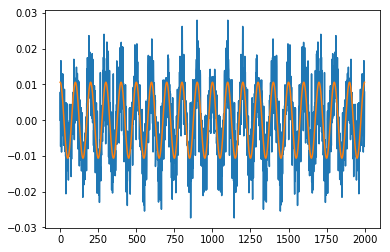

In [19]:
times = np.linspace(0, epoch_dur, int(epoch_dur * fs))
#signal = np.empty((len(subjs), len(trials), len(times)))

fourier_freqs = np.fft.rfftfreq(len(times), d=1/fs)
alpha_freqs = np.where(np.logical_and(fourier_freqs > 8, fourier_freqs < 12))[0]
not_alpha_freqs = np.where(np.logical_or(fourier_freqs < 7, fourier_freqs > 13))[0]
fourier_coefs = np.zeros((len(subjs), len(trials), len(fourier_freqs)))
# for simplicity, just put all the power in a single frequency bin near the middle of the alpha band
freq_bin = len(alpha_freqs) // 2
fourier_coefs[:, :, alpha_freqs[freq_bin]] = np.sqrt(alpha_powers)

# generate the signals
signal = np.fft.irfft(fourier_coefs, axis=-1)

# make sure we didn't screw up:
powr = np.fft.rfft(signal, axis=-1)
powr = (powr * powr).sum(axis=-1)
assert np.allclose(alpha_powers, powr)

# add some energy outside alpha band
fourier_coefs[:, :, not_alpha_freqs] = rng.rand(len(not_alpha_freqs))
signal_plus_noise = np.fft.irfft(fourier_coefs, axis=-1)
signal_plus_noise[:, :, 0] = 0.  # hack to avoid cosine phase issue

plt.plot(signal_plus_noise[0,0,:])
plt.plot(signal[0,0,:])

# Generate `Epochs` objects
Now that we have some (fake) data, let's get it into `mne-python` format.  If you're working with real data, you would skip all the synthesis above and start here.

In [20]:
mne.epochs.EpochsArray?

In [21]:
# TODO: create event dict, etc
# info = XXX
# events = np.zeros((len(trials), 3))
# event_id = dict()
# epochs = mne.epochs.EpochsArray(signal_plus_noise, info, events, proj=False)

## Compute alpha power

In [23]:
# TODO

# Do the stats

First, we will consider the following **mixed-effects model**:

\begin{equation}
  \log y_{c,j,i} = \beta_0 + \beta_c + \beta_j + \epsilon_{c,j,i}
\end{equation}

$\epsilon_{c,j,i} \sim \mathcal{N}(0, \sigma_j)$

In [24]:
#%%R -o foo -i bar
#foo <- data.frame(A=rnorm(4), B=rpois(4, 0.5))
#print(bar)